In [1]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import cvxpy as cp
import os
from time import time
import pickle

import utils
import APG_CG
import setup
import helper
import algos


from utils import *
from APG_CG import *
from setup import *
from helper import *
from algos import *
# import sparse

import importlib
importlib.reload(utils)
importlib.reload(APG_CG)
importlib.reload(setup)
importlib.reload(algos)
importlib.reload(helper)

<module 'helper' from '/Users/aditi/Documents/Rigorous_MLE/Pauli_povm_CPU/helper.py'>

In [49]:
nQubits = 5
m = 4**nQubits-1
nShots = 100*m
trueRank = 1
approxRank = np.maximum(1, int(2**nQubits/4))
noise = 0.1
Wstate = True

rho_true, u_true, yp, ym, Ap, count, mList, fi = createSetupQST(nQubits, nShots=nShots, r=trueRank, Wstate = Wstate, Depolarize = noise, lowmem=False)
if Ap is None:
    Am = None
else:
    Am = scipy.sparse.identity(2**nQubits) - Ap

if Ap is not None:
    A = sparse.concat((Ap, Am))
else:
    A = None    
# y = np.hstack([yp, ym])/nShots
y = np.hstack([yp/count, ym/count])

set_param = {'nQubits': nQubits,
            'rank': approxRank,
            'depolarize': noise,
            'max_iter1':200,
            'max_iter2':500,
            'warmstart':1,
            'r_svd': approxRank,
            'eta': 0.3,
            'eps_coeff': 0.08,
            'c_eps':10,
            'n_rate': 1,
            'save': 0, 
            'cvxSolver': None, 
            'timeLimit': 3600}

if Wstate is True:
    set_param = {**set_param, 'state': 'Wstate'}
else:
    set_param = {**set_param, 'state': None}


param = {**set_param, **{'fun':utils.fun,
         'gradf':utils.grad,
         'rho_true':rho_true,
        #  'y':y,
         'y':y,
         'A':A}}

if mList is not None:
    param = {**param, **{'mList':mList}}


dir = "/Users/aditi/Documents/QST_camera_ready/results/data/maxcor_2"
# dir2 = os.path.join(dir, 'figures')
file_type = 'pickle'

In [ ]:
algo_list = [qse_apg]
output1 = run_experiment(algo_list, os.path.join(dir), file_type, **param)

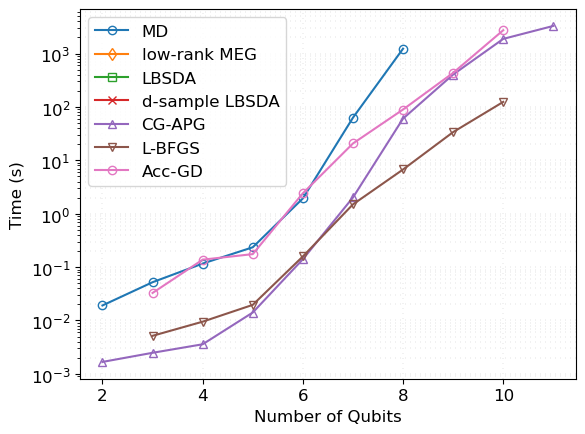

In [26]:
algo_list = [EMD, approx_MEG,LBSDA, d_LBSDA, qse_apg, LBFGS, AccGD]
plot_fval_vs_qubits("/Users/aditi/Documents/QST_camera_ready/results/data/maxcor_2", algo_list)#, "/Users/aditi/Documents/QST_camera_ready/results/figures")

dict_keys(['qse_apg', 'LBFGS', 'nQubits', 'warmstart', 'r_svd', 'eta', 'eps_coeff', 'c_eps', 'n_rate', 'rho_true', 'y', 'time_limit', 'AccGD'])
/Users/aditi/Documents/Rigorous_MLE/Pauli_povm_CPU/results/figures/error_vs_iter_maxcor_2.pdf


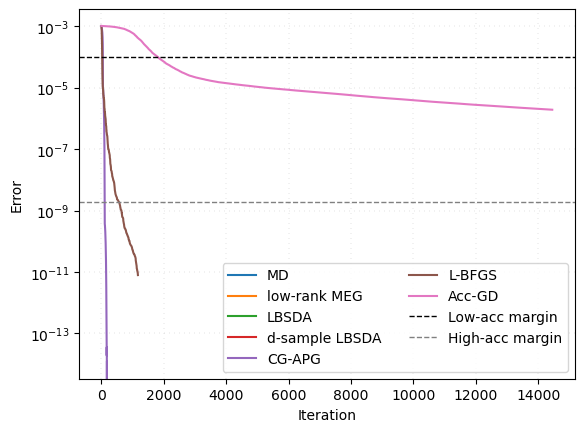

In [4]:
algo_list = [EMD, approx_MEG,LBSDA, d_LBSDA, qse_apg, LBFGS, AccGD]
plot_error_vs_iter("/Users/aditi/Documents/Rigorous_MLE/Pauli_povm_CPU/results/r_d_4/maxcor_2", algo_list, 9, "/Users/aditi/Documents/Rigorous_MLE/Pauli_povm_CPU/results/figures")

In [ ]:
import scipy.sparse
import scipy.sparse.linalg

prob = qst1(output1['LBFGS']['rho'], nQubits)
prob = np.concatenate([0.5*(prob[0]+ prob[1:]), 0.5*(prob[0]- prob[1:])])
eta = np.sum(y/prob)

gradient = grad(output1['LBFGS']['rho'], nQubits, y, primitive1= qst1, primitive2=qst2)
B = eta*np.eye(2**nQubits) - gradient
max_eig_B, _ = scipy.sparse.linalg.eigsh(B,k = 1,  which = 'LM')

# true = scipy.sparse.linalg.eigsh(gradient, k = 1, which = 'SA')[0]
mu = (eta-max_eig_B)
mu = - mu 
print(mu)

sigma = gradient + mu*np.eye(2**nQubits)
np.trace(sigma.conj().T@rho_true)

# plot duality gap

In [ ]:
from matplotlib.legend_handler import HandlerTuple
from matplotlib.ticker import LogLocator
from matplotlib import pyplot as plt, ticker as mticker

param = {}
algo_list = [LBFGS]
fig, axs = plt.subplots(1,1)
legend_handles = []
legend_labels = []

colors=['red', 'green']
c = 0

# dir = "/Users/aditi/Documents/QST_camera_ready/results/maxcor_2"
dir = "/Users/aditi/Documents/QST_camera_ready/Pauli_povm_CPU/results/r_d_4/maxcor_2"
for filename in os.listdir(dir):
    file_path = os.path.join(dir, filename)
    # check for .pickle file
    if filename.endswith('.pickle'):
        #read content
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            if data['nQubits'] in [5, 4]:
                param['nQubits'] = data['nQubits']
                param['rho_true'] = data['rho_true']
                param['y'] = data['y']
                param['save'] = 0
                param['r_svd'] = data['r_svd']
                print(data['nQubits'])
                param['fun'] = fun
                param['gradf'] = grad
                param['cvxSolver'] = 'SCS'
                param['timeLimit'] = data['time_limit']

                m = 4**param['nQubits']
                nShots = 100*m
                _, _, _, _, Ap, _, _, _ = createSetupQST(param['nQubits'], nShots=nShots)
                Am = scipy.sparse.identity(2**param['nQubits']) - Ap
                A = sparse.concat((Ap, Am))
                param['A'] = A

                cvx_sol = cvxpy_convex(**param)
                cvx_fval = utils.fun(cvx_sol, param['nQubits'], param['y'], primitive1 = qst1, primitive2 = qst2)

                out = LBFGS(**param)
                gap = out['gap']
                label_base = f'n = {param["nQubits"]}'
                p1, = axs.semilogy(gap, color = colors[c], linestyle = 'dashed')
                p2, = axs.semilogy(np.real_if_close(out['fval'])-cvx_fval, color = colors[c], linestyle = 'solid')

                axs.set_xlabel('iteration')
                axs.set_ylabel('error')
                legend_handles.extend([p1, p2])
                legend_labels.extend([f'Error bound, {label_base}', f'Actual error, {label_base}'])
                plt.grid(True, which='both', linestyle='--', alpha = 1.0 , linewidth = 0.3, dashes=(2, 10))
                fontSize=12
                plt.rcParams.update({
                'font.size': fontSize,         # Set font size for labels, legends, and ticks
                'axes.labelsize': fontSize,    # X and Y labels
                'legend.fontsize': fontSize,   # Legend
                'xtick.labelsize': fontSize,   # X-axis tick labels
                'ytick.labelsize': fontSize    # Y-axis tick labels
                })
                c += 1

# Add legend after the loop
axs.legend(legend_handles, legend_labels, loc='best')
plt.show()
                
fig.savefig("/Users/aditi/Documents/QST_camera_ready/Pauli_povm_CPU/results/figures/duality_gap_revised.pdf", format='pdf')
                
               


    

# add results to exisiting data files

In [ ]:
cvx_sol = {}
algo_list = [qse_apg]
dir = "/Users/aditi/Documents/QST_camera_ready/results/data/maxcor_2"
for filename in os.listdir(dir):
    file_path = os.path.join(dir, filename)
    # check for .pickle file
    if filename.endswith('.pickle'):
        #read content
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            if data['nQubits'] == 11:
                param = {}
                param['nQubits'] = data['nQubits']
                
                param['rho_true'] = data['rho_true']
                param['y'] = data['y']
                param['save'] = 0
                param['r_svd'] = data['r_svd']
                print(param['nQubits'], param['r_svd'])
                param['fun'] = fun
                param['gradf'] = grad
                param['cvxSolver'] = 'SCS'
                param['timeLimit'] = data['time_limit']
                param['warmstart'] = data['warmstart']
                param['eta'] = data['eta']
                param['eps_coeff'] = data['eps_coeff']
                param['c_eps'] = data['c_eps']
                param['n_rate'] = data['n_rate']
                param['state'] = 'Wstate'
                param['depolarize'] = 0.1

                output = run_experiment(algo_list, **param)
                # print(fidelity(output['AccGD']['rho'],  param['rho_true']))
                data.update(output)
                
                save_experiment(data, "/Users/aditi/Documents/QST_camera_ready/results/data", 'pickle', **param)
                


    

# LBFGS for different history sizes for hessian

In [ ]:
dir = "/Users/aditi/Documents/QST_camera_ready/results/data/"
save_destination = "/Users/aditi/Documents/QST_camera_ready/results/figures"
subdirectories = []
for root, dirs, files in os.walk(dir):
    subdirectories.extend([os.path.join(root, d) for d in dirs])

subdirectories = sorted(subdirectories, key=lambda x: int(x.split('_')[-1]))
# print("All Subdirectories:", subdirectories)
plt.figure()
algo_list = [EMD, LBSDA, d_LBSDA, qse_apg, LBFGS]
algo_list = [algo.__name__ for algo in algo_list]
output = {}
case = []
for subdir in subdirectories:
    case.append(subdir.rsplit('_', 1)[-1])
    #get file names
    for filename in os.listdir(subdir):
        nQubits = []
        file_path = os.path.join(subdir, filename)
        # print(file_path)
        # check for .pickle file
        if filename.endswith('.pickle'):
            #read content
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                nQubits.append(data['nQubits'])
                fval_min = np.inf
                for algo in algo_list:
                    if algo in data:
                        fval = data[algo]['fval']
                        fval_min = np.minimum(fval_min, np.min(fval))

                N = 4**(nQubits[-1])* 100       
                for algo in algo_list: 
                    if algo == 'LBFGS': 
                        fval = data[algo]['fval']
                        condition = (fval-fval_min) <= 1e-4 #-1/N * np.log(0.95)
                        idx = np.argmax(condition)
                        cumulative_time = data[algo]['elapsed_time']
                        time_taken = cumulative_time[idx] if condition[idx] else np.inf
                        output[data['nQubits']] = time_taken
                    else:
                        output[data['nQubits']] = np.inf           

    sorted_dict = dict(sorted(output.items()))

    # Plot the data
    markers = {'1' :'o', '2':'d', '5':'s', '10':'x'}
    linestyles = {'1' :'--', '2':'-', '5':'--', '10':'--'}
    # plt.figure(figsize=(10, 6))
    fontSize=12
    plt.rcParams.update({
    'font.size': fontSize,         # Set font size for labels, legends, and ticks
    'axes.labelsize': fontSize,    # X and Y labels
    'legend.fontsize': fontSize,   # Legend
    'xtick.labelsize': fontSize,   # X-axis tick labels
    'ytick.labelsize': fontSize    # Y-axis tick labels
    })

    plt.semilogy(sorted_dict.keys(), sorted_dict.values(), 
                 marker=markers[case[-1]], markerfacecolor='none', linestyle=linestyles[case[-1]],
                 label = 'history size = '+ case[-1])
    output = {}
plt.xlabel('Number of Qubits')
plt.ylabel('Time (s)')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', alpha = 1.0 , linewidth = 0.3, dashes=(2, 10))
plt.savefig(save_destination +'/LBFGS_histSize_low_acc.pdf', format='pdf')
    
plt.show()
    